# Model Bias in NLP - Application to Hate Speech - Benchmark Models

---



# Import of Libraries and Kaggle Dataset

In [1]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer  
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, GRU, Dropout,Embedding ,Dense, GlobalAveragePooling1D, GlobalMaxPooling1D
import pandas as pd
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pickle
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
# Download Kaggle Dataset via the Kaggle API

kaggle_api = {"username":"bojonas","key":"1b3903e6a0f6c0bb4c684ade1e291321"}

import json
with open('/content/kaggle.json', 'w') as file:
    json.dump(kaggle_api, file)

!chmod 600 /content/kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

!unzip \*.zip  && rm *.zip

 93% 60.0M/64.7M [00:03<00:00, 10.7MB/s]
100% 64.7M/64.7M [00:03<00:00, 18.7MB/s]
 57% 9.00M/15.9M [00:00<00:00, 12.3MB/s]
100% 15.9M/15.9M [00:00<00:00, 19.9MB/s]
 74% 9.00M/12.1M [00:01<00:00, 7.08MB/s]
100% 12.1M/12.1M [00:01<00:00, 8.67MB/s]
  0% 0.00/224k [00:00<?, ?B/s]
100% 224k/224k [00:00<00:00, 21.0MB/s]
 98% 270M/276M [00:11<00:00, 25.3MB/s]
100% 276M/276M [00:11<00:00, 24.4MB/s]
 73% 9.00M/12.3M [00:01<00:00, 7.47MB/s]
100% 12.3M/12.3M [00:01<00:00, 8.21MB/s]
 95% 15.0M/15.8M [00:01<00:00, 5.59MB/s]
100% 15.8M/15.8M [00:01<00:00, 11.3MB/s]
 97% 316M/326M [00:10<00:00, 19.8MB/s]
100% 326M/326M [00:10<00:00, 32.2MB/s]
Archive:  identity_individual_annotations.csv.zip
  inflating: identity_individual_annotations.csv  

Archive:  test_public_expanded.csv.zip
  inflating: test_public_expanded.csv  

Archive:  all_data.csv.zip
  inflating: all_data.csv            

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test_private_expanded.csv.zip
 

# Data Exploration

In [ ]:
# Read training data and sample it to 600'000 samples

train = pd.read_csv("/content/train.csv")

train = train.head(600000)

data = train[["comment_text", "target"]]

data.shape

(600000, 2)

(array([422360.,  52829.,  55987.,   1941.,  18798.,  23931.,   8842.,
          4891.,   7312.,   3109.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

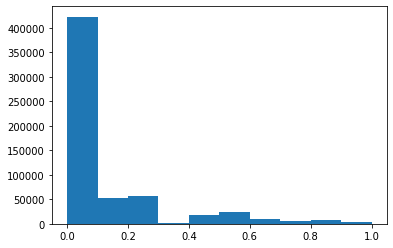

In [ ]:
plt.hist(data["target"])

# Text Cleaning/Preprocessing

In [ ]:
# Source: https://www.kaggle.com/raisulju/jigsaw-unintended-bias-eda-preprocessing

from bs4 import BeautifulSoup # Text Cleaning
import re, string # Regular Expressions, String
import nltk
from nltk.corpus import stopwords # stopwords
from nltk.stem.porter import PorterStemmer # for word stemming
from nltk.stem import WordNetLemmatizer # for word lemmatization
import unicodedata
import html

nltk.download('stopwords')
nltk.download('wordnet')

# set of stopwords to be removed from text
stop = set(stopwords.words('english'))

# update stopwords to have punctuation too
stop.update(list(string.punctuation))

def clean_text(text):
    
    # Remove unwanted html characters
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
    'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
    '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
    ' @-@ ', '-').replace('\\', ' \\ ')
    text = re1.sub(' ', html.unescape(x1))
    
    # remove non-ascii characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # remove between square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # remove twitter tags
    text = text.replace("@", "")
    
    # remove hashtags
    text = text.replace("#", "")
    
    # remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # remove stopwords from text
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip().lower())
    
    text = " ".join(final_text)
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()    
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])
    
    # replace all numbers with "num"
    text = re.sub("\d", "num", text)
    
    return text.lower()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data['clean_comment_text'] = data["comment_text"].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Sequence Length Analysis

(array([2.88366e+05, 1.43531e+05, 7.33950e+04, 3.80090e+04, 3.70110e+04,
        1.94430e+04, 2.35000e+02, 1.00000e+00, 7.00000e+00, 2.00000e+00]),
 array([  0. ,  17.4,  34.8,  52.2,  69.6,  87. , 104.4, 121.8, 139.2,
        156.6, 174. ]),
 <a list of 10 Patch objects>)

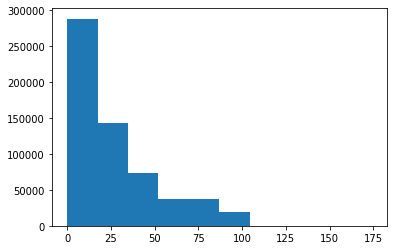

In [ ]:
plt.hist(list(data['clean_comment_text'].str.split().map(lambda x: len(x))))

In [ ]:
np.median(np.array(data['clean_comment_text'].str.split().map(lambda x: len(x))))

18.0

# Tokenize/Pad Sequence

In [ ]:
# Tokenize to 10'000 words and pad to 128 words per comment

tokenizer = Tokenizer(num_words=10000, oov_token="UNK")
tokenizer.fit_on_texts(data['clean_comment_text'])
X = tokenizer.texts_to_sequences(data['clean_comment_text'])

max_length = 128
X = pad_sequences(X, max_length, truncating = 'post', padding='post')

In [ ]:
num_words = len(tokenizer.word_index)
print(f"Number of unique words: {num_words}")

Number of unique words: 383916


In [ ]:
Y = data["target"]

In [ ]:
# Apply thresholding to Y
Y[Y >= 0.5] = 1
Y[Y < 0.5] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing 

In [ ]:
print(X.shape)
print(Y.shape)

(600000, 128)
(600000,)


# Get Embedding for first Layer with GloVE pretrained model

In [ ]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip

--2021-07-11 15:06:27--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2021-07-11 15:06:27--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-07-11 15:06:27--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [ ]:
EMBEDDING_FILES = ['glove.840B.300d.txt']

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)

In [ ]:
# Source: https://www.kaggle.com/christofhenkel/how-to-preprocessing-for-glove-part2-usage

def build_matrix(word_index, path):
    """
    path: a path that contains embedding matrix
    word_index is a dict of the form ('apple': 123, 'banana': 349, etc)
    
    we will construct an embedding_matrix for the words in word_index
    using pre-trained embedding word vectors from 'path'
    """
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [ ]:
embedding_matrix = np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)

# Check for GPU Support

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Optional: Save/Load already preprocessed data

## Save data

In [ ]:
pickle.dump(X, open( "X.pkl", "wb" ))
pickle.dump(Y, open( "Y.pkl", "wb" ))
pickle.dump(embedding_matrix, open( "embedding_matrix.pkl", "wb" ))
pickle.dump(tokenizer, open( "tokenizer.pkl", "wb" ))

## Load Data

In [ ]:
X = pickle.load( open( "X.pkl", "rb" ) )
Y = pickle.load( open( "Y.pkl", "rb" ) )
embedding_matrix = pickle.load( open( "embedding_matrix.pkl", "rb" ) )
tokenizer = pickle.load( open( "tokenizer.pkl", "rb" ) )

# Do the train/test split

In [ ]:
# Train Test split for training/testing

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

print("X_train shape:" + str(X_train.shape))
print("Y_train shape:" + str(Y_train.shape))
print("------------------------------")
print("X_test shape:" + str(X_test.shape))
print("Y_test shape:" + str(Y_test.shape))

X_train shape:(540000, 128)
Y_train shape:(540000,)
------------------------------
X_test shape:(60000, 128)
Y_test shape:(60000,)


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Define LSTM Model (Baseline 1)

In [ ]:
# Define Keras LSTM Model with embedding layer

model = Sequential()
model.add(Embedding(*embedding_matrix.shape, weights = [embedding_matrix], input_length = max_length, trainable = False))
model.add(LSTM(128, return_sequences = True))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 300)          115175100 
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 128)          219648    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 115,394,877
Trainable params: 219,777
Non-trainable params: 115,175,100
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), f1_m,precision_m, recall_m])

batch_size = 512
epochs = 5

model.fit(X_train, Y_train, epochs=epochs, batch_size = batch_size, validation_data = (X_test, Y_test))

Epoch 1/5
1055/1055 [==============================] - 95s 54ms/step - loss: 0.2312 - accuracy: 0.9229 - recall_3: 0.1210 - auc_3: 0.6790 - f1_m: 0.2634 - precision_m: 0.4225 - recall_m: 0.2139 - val_loss: 0.1526 - val_accuracy: 0.9436 - val_recall_3: 0.3537 - val_auc_3: 0.8922 - val_f1_m: 0.5084 - val_precision_m: 0.7983 - val_recall_m: 0.3771
Epoch 2/5
1055/1055 [==============================] - 57s 54ms/step - loss: 0.1468 - accuracy: 0.9459 - recall_3: 0.3753 - auc_3: 0.9013 - f1_m: 0.5825 - precision_m: 0.7617 - recall_m: 0.4802 - val_loss: 0.1478 - val_accuracy: 0.9447 - val_recall_3: 0.4181 - val_auc_3: 0.9152 - val_f1_m: 0.6073 - val_precision_m: 0.6865 - val_recall_m: 0.5498
Epoch 3/5
1055/1055 [==============================] - 57s 54ms/step - loss: 0.1409 - accuracy: 0.9474 - recall_3: 0.4291 - auc_3: 0.9183 - f1_m: 0.6032 - precision_m: 0.7727 - recall_m: 0.5036 - val_loss: 0.1413 - val_accuracy: 0.9463 - val_recall_3: 0.4465 - val_auc_3: 0.9241 - val_f1_m: 0.5814 - val_pr

# Define GRU Model (Baseline 2)

In [ ]:
model = Sequential()
model.add(Embedding(*embedding_matrix.shape, weights = [embedding_matrix], input_length = max_length, trainable = False))
model.add(GRU(128, return_sequences = True))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 128, 300)          115175100 
_________________________________________________________________
gru_1 (GRU)                  (None, 128, 128)          165120    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 115,340,349
Trainable params: 165,249
Non-trainable params: 115,175,100
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC(),f1_m,precision_m, recall_m])

batch_size = 512
epochs = 5

model.fit(X_train, Y_train, epochs=epochs, batch_size = batch_size, validation_data = (X_test, Y_test))

Epoch 1/5
1055/1055 [==============================] - 56s 49ms/step - loss: 0.2116 - accuracy: 0.9344 - recall_6: 0.1894 - auc_6: 0.7345 - f1_m: 0.3789 - precision_m: 0.5590 - recall_m: 0.2990 - val_loss: 0.1472 - val_accuracy: 0.9455 - val_recall_6: 0.4061 - val_auc_6: 0.9066 - val_f1_m: 0.5785 - val_precision_m: 0.7341 - val_recall_m: 0.4820
Epoch 2/5
1055/1055 [==============================] - 51s 48ms/step - loss: 0.1448 - accuracy: 0.9466 - recall_6: 0.4220 - auc_6: 0.9129 - f1_m: 0.5888 - precision_m: 0.7725 - recall_m: 0.4836 - val_loss: 0.1414 - val_accuracy: 0.9464 - val_recall_6: 0.4456 - val_auc_6: 0.9229 - val_f1_m: 0.5821 - val_precision_m: 0.7441 - val_recall_m: 0.4830
Epoch 3/5
1055/1055 [==============================] - 51s 48ms/step - loss: 0.1377 - accuracy: 0.9486 - recall_6: 0.4522 - auc_6: 0.9253 - f1_m: 0.6072 - precision_m: 0.7817 - recall_m: 0.5060 - val_loss: 0.1422 - val_accuracy: 0.9462 - val_recall_6: 0.4656 - val_auc_6: 0.9296 - val_f1_m: 0.6095 - val_pr

# Define Advanced LSTM Model (Baseline 3)

In [ ]:
# We use the Keras Functional API for that
words = Input(shape=(max_length,))

x = Embedding(*embedding_matrix.shape, weights = [embedding_matrix], input_length = max_length, trainable = False)(words)
x = SpatialDropout1D(0.3)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)

hidden = concatenate([GlobalMaxPooling1D()(x),GlobalAveragePooling1D()(x),])
hidden = add([hidden, Dense(512, activation='relu')(hidden)])
hidden = add([hidden, Dense(512, activation='relu')(hidden)])

result = Dense(1, activation='sigmoid')(hidden)

model = Model(inputs=words, outputs=[result])

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC() , f1_m,precision_m, recall_m])

In [ ]:
batch_size = 512
epochs = 5

model.fit(X_train, Y_train, epochs=epochs, batch_size = batch_size, validation_data = (X_test, Y_test))

Epoch 1/5
1055/1055 [==============================] - 214s 197ms/step - loss: 0.1907 - accuracy: 0.9341 - recall_7: 0.2042 - auc_7: 0.8022 - f1_m: 0.3893 - precision_m: 0.5961 - recall_m: 0.3031 - val_loss: 0.1459 - val_accuracy: 0.9449 - val_recall_7: 0.3980 - val_auc_7: 0.9128 - val_f1_m: 0.5872 - val_precision_m: 0.7115 - val_recall_m: 0.5045
Epoch 2/5
1055/1055 [==============================] - 178s 169ms/step - loss: 0.1476 - accuracy: 0.9449 - recall_7: 0.4136 - auc_7: 0.9175 - f1_m: 0.5725 - precision_m: 0.7615 - recall_m: 0.4664 - val_loss: 0.1473 - val_accuracy: 0.9438 - val_recall_7: 0.4391 - val_auc_7: 0.9248 - val_f1_m: 0.6202 - val_precision_m: 0.6584 - val_recall_m: 0.5920
Epoch 3/5
1055/1055 [==============================] - 179s 169ms/step - loss: 0.1394 - accuracy: 0.9473 - recall_7: 0.4478 - auc_7: 0.9268 - f1_m: 0.5951 - precision_m: 0.7628 - recall_m: 0.4961 - val_loss: 0.1388 - val_accuracy: 0.9467 - val_recall_7: 0.4588 - val_auc_7: 0.9305 - val_f1_m: 0.5662 - 

# Optional: Save/Load already trained model

## Save model

In [ ]:
pickle.dump(model, open( "model.pkl", "wb" ))

## Load model

In [ ]:
model = pickle.load( open( "model.pkl", "rb" ) )

# History Plots

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict custom text

In [ ]:
text = pd.DataFrame(index=[0], columns=["comment_text"])
text["comment_text"] = "oh silly"

text = text["comment_text"].apply(clean_text)

text = tokenizer.texts_to_sequences(text)
text = pad_sequences(text, max_length, truncating = 'post', padding='post')

score = model.predict(text)

print(score)

# Predict Kaggle Test Set

In [ ]:
# Read test data

test = pd.read_csv("/content/test.csv")

test["clean_comment_text"] = test['comment_text'].apply(clean_text)

X_kaggle_test = tokenizer.texts_to_sequences(test["clean_comment_text"])
X_kaggle_test = pad_sequences(X_kaggle_test, max_length, truncating = 'post', padding='post')

In [ ]:
kaggle_predict = model.predict(X_kaggle_test, batch_size=2048)

In [ ]:
submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': kaggle_predict.flatten()
 })

submission.to_csv('submission.csv', index=False)